In [37]:
from __future__ import print_function
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
import sklearn.datasets

from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [38]:
df_all = pd.read_csv('./dataset/telcom_customer_churn.csv')

In [39]:
df_train = pd.read_csv('./train/telcom_churn_train.csv')
df_train.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,35.48,151.50,44.99,0.49,0.00,0.00,0.00,0.00,0.00,-16.50,...,0.00,N,U,U,U,Y,Y,Y,352.00,1087158
1,133.18,834.00,69.99,1.24,184.75,73.90,73.90,0.00,0.00,72.00,...,0.00,N,U,U,U,U,U,N,24.00,1071989
2,126.63,1276.00,90.39,1.24,81.75,24.73,24.57,0.15,3.68,-272.00,...,0.00,N,U,U,U,U,U,N,155.00,1048125
3,33.73,330.50,39.99,0.00,0.00,0.00,0.00,0.00,0.00,-52.50,...,0.00,H,U,U,U,U,Y,Y,328.00,1058350
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,S,U,U,U,U,U,Y,816.00,1099661


In [40]:
df_test = pd.read_csv('./test/telcom_churn_test.csv')

In [41]:
print(df_all.shape)
print(df_train.shape)
print(df_test.shape)

(100000, 100)
(69999, 100)
(20001, 100)


In [42]:
df_train.churn.value_counts()

0    35306
1    34693
Name: churn, dtype: int64

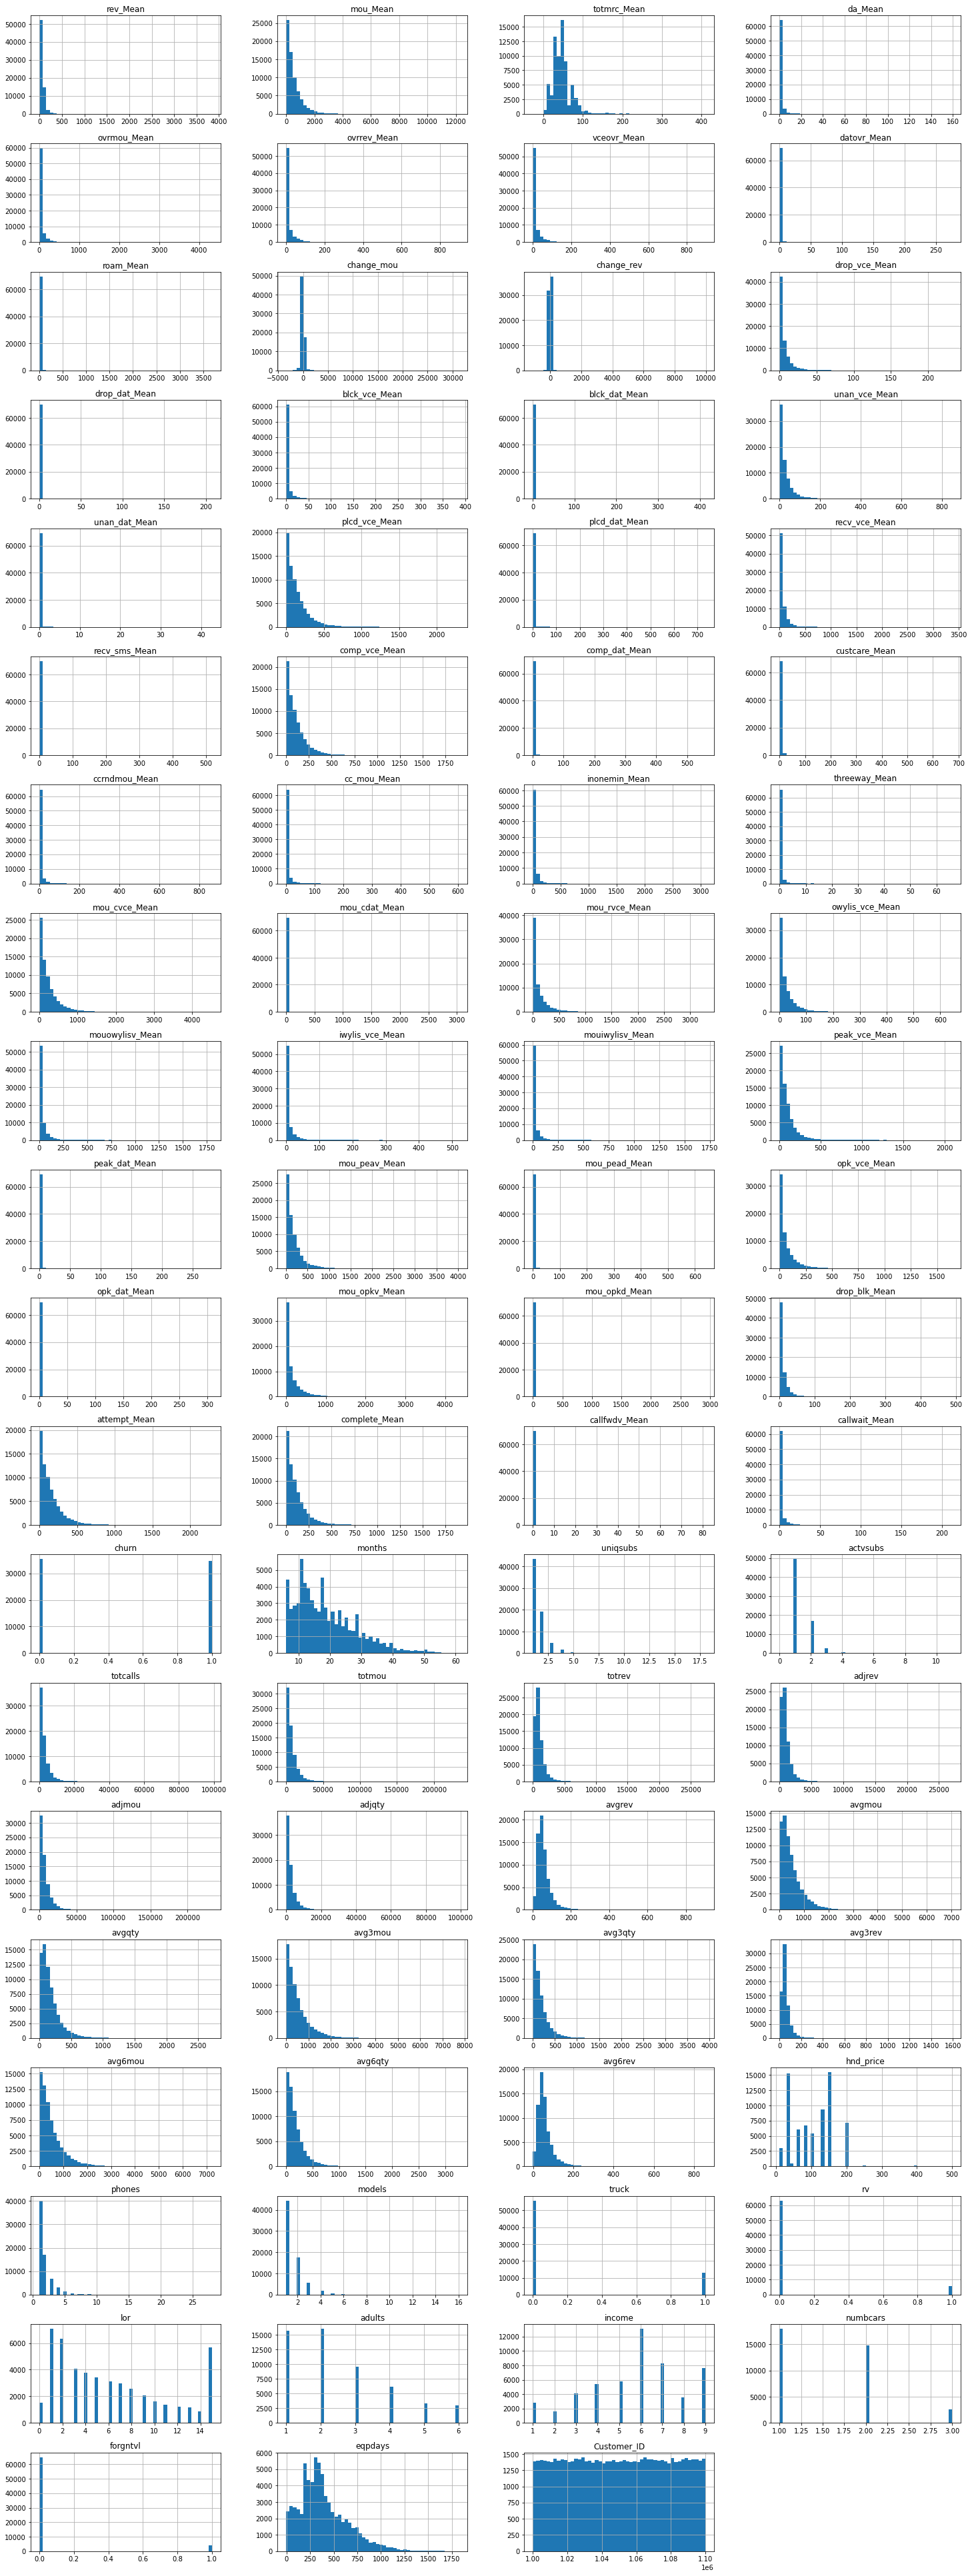

In [43]:
df_train.iloc[:,:].hist(bins=50,figsize=(25,70),layout=(-1,4));

In [44]:
miss = df_train.isnull().sum().sort_values(ascending = False).head(40)
miss_per = (miss/len(df_train))*100
pd.DataFrame({'No. missing values': miss, '% of missing data': miss_per.values})

,No. missing values,% of missing data
numbcars,34661,49.52
dwllsize,26868,38.38
HHstatin,26521,37.89
ownrent,23627,33.75
dwlltype,22393,31.99
lor,21169,30.24
income,17830,25.47
adults,16126,23.04
infobase,15457,22.08
hnd_webcap,7106,10.15


In [45]:
def impute_NA_with_avg(data,strategy='mean',NA_col=[]):
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            if strategy=='mean':
                data_copy[i] = data_copy[i].fillna(data[i].mean())
            elif strategy=='median':
                data_copy[i] = data_copy[i].fillna(data[i].median())
            elif strategy=='mode':
                data_copy[i] = data_copy[i].fillna(data[i].mode()[0])
        else:
            warnings.warn("Нет пропущенных значений" % i)
    return data_copy

def impute_outlier_std(data,cols=[],threshold=3):
    data_copy = data.copy(deep=True)
    for col in cols:
        Upper_fence = data_copy[col].mean() + threshold * data_copy[col].std()
        Lower_fence = data_copy[col].mean() - threshold * data_copy[col].std()  
        data_copy[col][data_copy[col] >= Upper_fence] = Upper_fence
        data_copy[col][data_copy[col] <= Lower_fence] = Lower_fence

    return data_copy

def fill_NA(data):
    df = data.copy()
    # df.drop(['numbcars','dwllsize','HHstatin','ownrent','dwlltype','lor'],axis=1,inplace=True)
    df.drop(['numbcars','dwllsize','HHstatin', 'dwlltype','income','adults','prizm_social_one','infobase','crclscod'], axis=1, inplace=True)
    df.drop(['Customer_ID'], axis=1, inplace=True)
    df.hnd_webcap = df.hnd_webcap.fillna('UNKW')
    df.ownrent = df.ownrent.fillna('UNKW')
    df = impute_NA_with_avg(df, strategy='mean', NA_col=['lor', 'rev_Mean', 'change_mou', 'change_rev'])
    df = impute_NA_with_avg(df, strategy='mean', NA_col=['avg6qty', 'avg6rev','avg6mou'])
    df = impute_NA_with_avg(df, strategy='mean', NA_col=['totmrc_Mean', 'da_Mean','ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'mou_Mean'])

    df.dropna(inplace=True)
    
    return df


In [46]:
df_all = impute_outlier_std(df_all, ['change_mou', 'change_rev'])
df_train = impute_outlier_std(df_train, ['change_mou', 'change_rev'])
df_test = impute_outlier_std(df_test, ['change_mou', 'change_rev'])
# Пробовал работать с аномалиями и по другим столбцам, но положительного эффекта на конечный результат не дало.

df_all = fill_NA(df_all)
df_train = fill_NA(df_train)
df_test = fill_NA(df_test)

In [47]:
sum(df_train.isnull().sum()>0)

0

In [48]:
sum(df_test.isnull().sum()>0)

0

In [49]:
cols = df_all.columns
num_cols = list(df_all._get_numeric_data().columns)
cat_cols = list(set(cols) - set(num_cols))

In [50]:
num_cols

['rev_Mean',
 'mou_Mean',
 'totmrc_Mean',
 'da_Mean',
 'ovrmou_Mean',
 'ovrrev_Mean',
 'vceovr_Mean',
 'datovr_Mean',
 'roam_Mean',
 'change_mou',
 'change_rev',
 'drop_vce_Mean',
 'drop_dat_Mean',
 'blck_vce_Mean',
 'blck_dat_Mean',
 'unan_vce_Mean',
 'unan_dat_Mean',
 'plcd_vce_Mean',
 'plcd_dat_Mean',
 'recv_vce_Mean',
 'recv_sms_Mean',
 'comp_vce_Mean',
 'comp_dat_Mean',
 'custcare_Mean',
 'ccrndmou_Mean',
 'cc_mou_Mean',
 'inonemin_Mean',
 'threeway_Mean',
 'mou_cvce_Mean',
 'mou_cdat_Mean',
 'mou_rvce_Mean',
 'owylis_vce_Mean',
 'mouowylisv_Mean',
 'iwylis_vce_Mean',
 'mouiwylisv_Mean',
 'peak_vce_Mean',
 'peak_dat_Mean',
 'mou_peav_Mean',
 'mou_pead_Mean',
 'opk_vce_Mean',
 'opk_dat_Mean',
 'mou_opkv_Mean',
 'mou_opkd_Mean',
 'drop_blk_Mean',
 'attempt_Mean',
 'complete_Mean',
 'callfwdv_Mean',
 'callwait_Mean',
 'churn',
 'months',
 'uniqsubs',
 'actvsubs',
 'totcalls',
 'totmou',
 'totrev',
 'adjrev',
 'adjmou',
 'adjqty',
 'avgrev',
 'avgmou',
 'avgqty',
 'avg3mou',
 'avg3qty

In [51]:
if 'churn' in num_cols:
    num_cols.remove('churn')

In [52]:
cat_cols

['creditcd',
 'new_cell',
 'kid16_17',
 'ethnic',
 'dualband',
 'kid11_15',
 'asl_flag',
 'area',
 'marital',
 'kid6_10',
 'hnd_webcap',
 'refurb_new',
 'kid0_2',
 'ownrent',
 'kid3_5']

In [53]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(df_all[cat_cols])

df_all_enc = pd.DataFrame(enc.transform(df_all[cat_cols]).toarray(), index=df_all.index, columns=enc.get_feature_names_out())
df_all = pd.concat([df_all.drop(cat_cols, axis=1), df_all_enc], axis=1)

In [54]:
df_train_enc = pd.DataFrame(enc.transform(df_train[cat_cols]).toarray(), index=df_train.index, columns=enc.get_feature_names_out())
df_train = pd.concat([df_train.drop(cat_cols, axis=1), df_train_enc], axis=1)

In [55]:
df_test_enc = pd.DataFrame(enc.transform(df_test[cat_cols]).toarray(), index=df_test.index, columns=enc.get_feature_names_out())
df_test = pd.concat([df_test.drop(cat_cols, axis=1), df_test_enc], axis=1)

In [56]:
df_train.shape

(68148, 144)

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [19]:
scaler = StandardScaler()

df_train_scale = scaler.fit_transform(df_train[num_cols])
df_test_scale = scaler.transform(df_test[num_cols])

In [20]:
df_train[num_cols] = df_train_scale
df_test[num_cols] = df_test_scale

X_train_scaled = df_train.drop(['churn'], axis=1).values
y_train = df_train['churn'].values

X_test_scaled = df_test.drop(['churn'], axis=1).values
y_test = df_test['churn'].values

### RandomForestClassifier

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import time

def randomized_cv(model, param_grid, x_train, y_train):
    grid_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='roc_auc')
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    print(grid_search.best_score_)
    return grid_search.best_estimator_

def plot_roc_curve(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()
    
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})

In [72]:
rf_param_grid = {"max_features": [10, 15],
                 "max_depth": [5, 12],
                "min_samples_split":[3,10, 15],
                "min_samples_leaf":[1,3,6],
                "n_estimators":[300, 500, 800],
                 "bootstrap": [False, True],
                 "n_jobs": [-1],
                "criterion":["gini"]}

clf = randomized_cv(RandomForestClassifier(), rf_param_grid, X_train_scaled, y_train)

y_pred = clf.predict_proba(X_test_scaled)[:,1]

model RandomForestClassifier best accuracy score is 0.6775965836680827
time for training is 4753.966765880585 seconds
0.6775965836680827


In [141]:
rf_best_params = {'bootstrap': False, 
                  'max_features': 15, 
                  'max_depth': 12, 
                  'min_samples_leaf': 6,
                  'min_samples_split': 3, 
                  'n_estimators': 800,
                  'n_jobs': -1,
}
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train_scaled, y_train)
y_pred = rf_clf.predict_proba(X_test_scaled)[:,1]
print("ROC AUC = ", roc_auc_score(y_test, y_pred))

ROC AUC =  0.6792032808435132


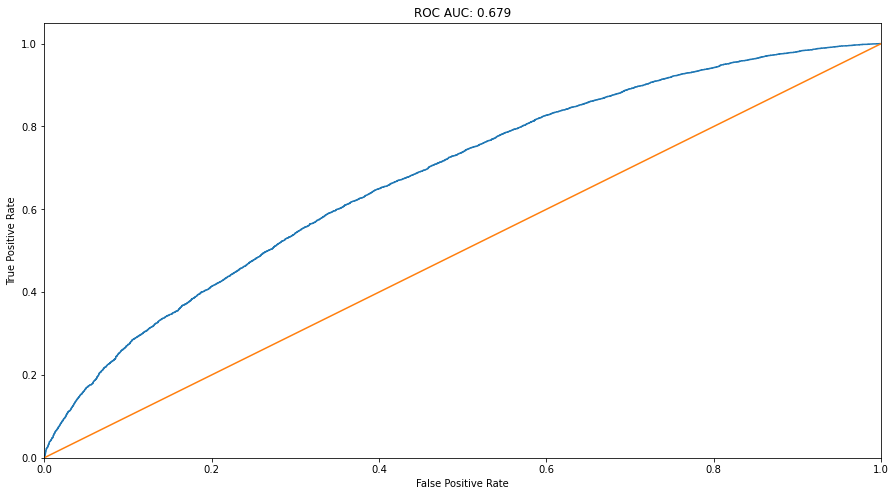

In [87]:
plot_roc_curve(y_test, y_pred)

### XGBClassifier

In [93]:
xgb_param_grid = {'n_estimators': [100, 200, 500],
          'learning_rate': [0.1, 0.3] ,
          'max_depth': [3, 5, 10],
          'min_child_weight': [1, 5, 15],
          'n_jobs': [4]}
clf_xgb = randomized_cv(XGBClassifier(), xgb_param_grid, X_train_scaled, y_train)
y_pred = clf_xgb.predict_proba(X_test_scaled)[:,1]

[13:16:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:16:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [95]:
y_pred = clf_xgb.predict_proba(X_test_scaled)[:,1]
roc_auc_score(y_test, y_pred)

0.6874444197269008

In [134]:
xgb_best_params = {'n_estimators': 500,
                  'max_depth': 3, 
                   'min_child_weight': 5,
                   'learning_rate': 0.1,
                  'n_jobs': -1,
}
best_clf_xgb = XGBClassifier(**xgb_best_params)
best_clf_xgb.fit(X_train_scaled, y_train, eval_metric='auc', eval_set=[[X_train_scaled, y_train], [X_test_scaled, y_test]])
y_pred = best_clf_xgb.predict_proba(X_test_scaled)[:,1]
print("ROC AUC = ", roc_auc_score(y_test, y_pred))

[0]	validation_0-auc:0.61289	validation_1-auc:0.61862
[1]	validation_0-auc:0.61581	validation_1-auc:0.62160
[2]	validation_0-auc:0.62294	validation_1-auc:0.62681
[3]	validation_0-auc:0.63027	validation_1-auc:0.63373
[4]	validation_0-auc:0.63052	validation_1-auc:0.63413
[5]	validation_0-auc:0.63443	validation_1-auc:0.63630
[6]	validation_0-auc:0.63630	validation_1-auc:0.63904
[7]	validation_0-auc:0.63702	validation_1-auc:0.64014
[8]	validation_0-auc:0.63902	validation_1-auc:0.64139
[9]	validation_0-auc:0.64021	validation_1-auc:0.64288
[10]	validation_0-auc:0.64088	validation_1-auc:0.64402
[11]	validation_0-auc:0.64255	validation_1-auc:0.64454
[12]	validation_0-auc:0.64378	validation_1-auc:0.64583
[13]	validation_0-auc:0.64433	validation_1-auc:0.64611
[14]	validation_0-auc:0.64603	validation_1-auc:0.64719
[15]	validation_0-auc:0.64769	validation_1-auc:0.64846
[16]	validation_0-auc:0.64898	validation_1-auc:0.64936
[17]	validation_0-auc:0.65013	validation_1-auc:0.65002
[18]	validation_0-au

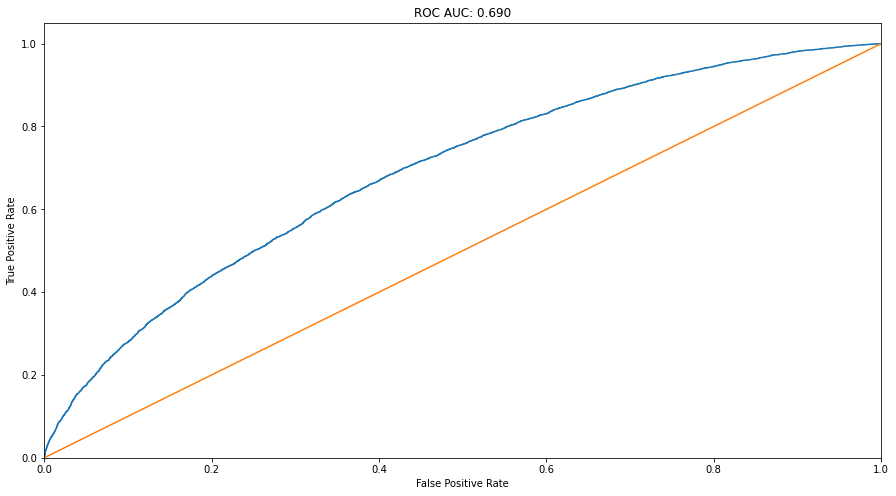

In [132]:
plot_roc_curve(y_test, y_pred)

Text(0.5, 0, 'iteration number')

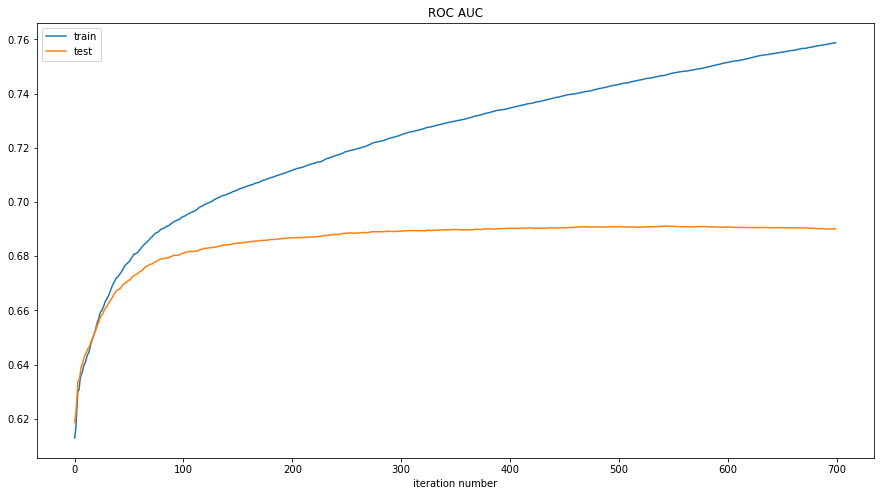

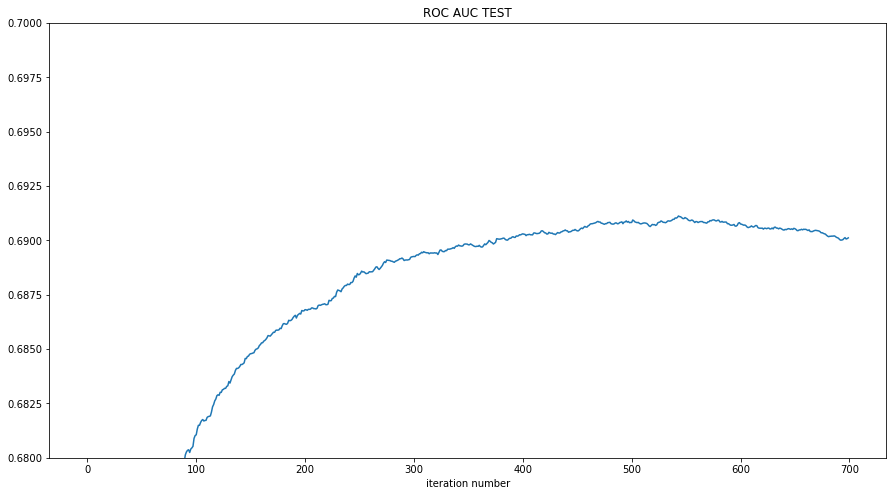

In [133]:
res = save_online_metric(best_clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.68, 0.70), title='ROC AUC TEST')
plt.xlabel('iteration number')

### Лучший ROC AUC = 0.69 (XGBClassifier)